# **Classification of Yoga pose**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Libraries

In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from matplotlib.image import imread
import plotly.express as px

In [ ]:
tf.config.list_physical_devices()  # APU device is visible to TensorFlow.

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
base_dir = '/content/drive/MyDrive/internship/yoga_detection/new_ds'
print('Number of pose to be predicted: ',len(os.listdir(base_dir)))

Number of pose to be predicted:  15


Viualize some of the Data

In [ ]:
## count number of images in each class
DF = pd.DataFrame(columns=['class','count'])
DF['class']=pd.Series([os.listdir(base_dir)[x] for x in range(0,15)])
DF['count']=pd.Series([len(os.listdir(os.path.join(base_dir,os.listdir(base_dir)[x]))) for x in range(0,15)])


<ipython-input-10-ae41f12b916e>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


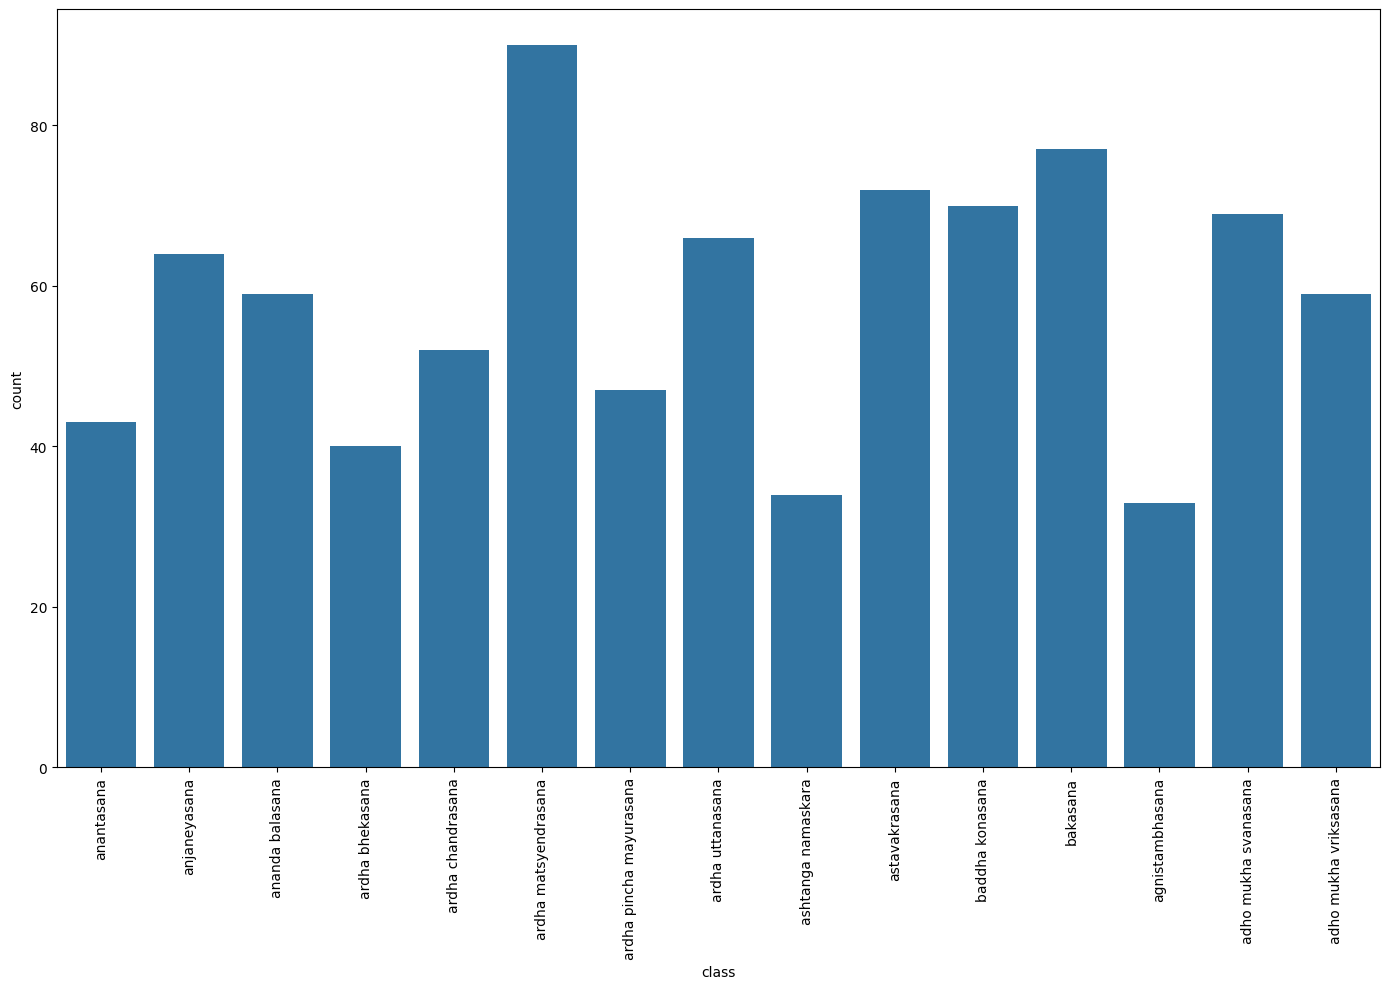

In [ ]:
import seaborn as sns
plt.figure(figsize=(14,10))
g=sns.barplot(x='class', y='count',data=DF)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.tight_layout()

# First Try: Simple CNN Model

Data Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./256,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  shear_range = 0.1,
                                  zoom_range= 0.1,
                                  horizontal_flip=True,
                                  fill_mode='nearest',
                                  validation_split=0.2)


In [ ]:
train_data = train_datagen.flow_from_directory(
    base_dir,
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training')

validation_data = train_datagen.flow_from_directory(
    base_dir,
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation')

Found 706 images belonging to 15 classes.
Found 168 images belonging to 15 classes.


In [ ]:
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense, Conv2D
# covnet
model = tf.keras.models.Sequential([Conv2D(128,(3,3),input_shape=(256,256,3),activation='relu'),
                                   Conv2D(128,(3,3)),
                                   MaxPool2D(2,2),
                                   Conv2D(64,(3,3)),
                                   Conv2D(64,(3,3)),
                                   MaxPool2D(2,2),
                                   Conv2D(32,(3,3)),
                                   Conv2D(32,(3,3)),
                                   MaxPool2D(2,2),
                                   Flatten(),
                                   Dense(1024,activation='relu'),
                                   Dense(512,activation='relu'),
                                   Dense(15,activation='softmax')])


In [ ]:
#compile
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
with tf.device(tf.DeviceSpec(device_type="GPU", device_index='0')):
    history = model.fit(train_data, steps_per_epoch=10,validation_data=validation_data, validation_steps=15, epochs=100,verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.01,patience=30,restore_best_weights=True)])

In [ ]:
model.evaluate(validation_data)

6/6 [==============================] - 5s 783ms/step - loss: 2.0538 - accuracy: 0.6250


[2.0537829399108887, 0.625]

In [ ]:
model.save('/content/drive/MyDrive/internship/yoga_detection/model_15class/my_model.h5')

In [5]:


model = tf.keras.models.load_model('/content/drive/MyDrive/internship/yoga_detection/model_15class/new_model.h5')


In [6]:
# prompt: need to test the model with an image

import numpy as np
test_image = Image.open('/content/drive/MyDrive/internship/yoga_detection/new_ds/adho mukha svanasana/1. 1.png')
test_image = test_image.resize((256, 256))
test_image = np.array(test_image)
test_image = test_image / 256.0
test_image = test_image[:, :, :3]
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
print(result)
predicted_class = np.argmax(result)

print("Predicted Class:", predicted_class)


1/1 [==============================] - 1s 723ms/step
[[9.8385632e-01 2.2946631e-10 6.2547671e-03 1.2520776e-07 3.4600220e-09
  1.5503833e-04 3.9159320e-07 3.9792972e-08 6.0856752e-03 3.6218928e-03
  4.4580779e-09 3.9987955e-07 1.7612287e-07 2.5161329e-05 5.7382232e-09]]
Predicted Class: 0


In [7]:

import numpy as np
test_image = Image.open('/content/drive/MyDrive/internship/yoga_detection/new_ds/adho mukha vriksasana/0-0.png')
test_image = test_image.resize((256, 256))
test_image = np.array(test_image)
test_image = test_image / 256.0
test_image = test_image[:, :, :3]
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
print(result)
predicted_class = np.argmax(result)

print("Predicted Class:", predicted_class)

1/1 [==============================] - 0s 448ms/step
[[5.2099571e-11 9.9999964e-01 9.6682502e-09 6.0732441e-09 1.0584134e-13
  1.5068275e-07 7.3201151e-13 6.5374428e-11 2.3480790e-07 6.5505490e-11
  1.3428988e-10 3.6009393e-18 1.4845103e-13 1.2122632e-08 1.7575205e-10]]
Predicted Class: 1


In [8]:

import numpy as np
test_image = Image.open('/content/drive/MyDrive/internship/yoga_detection/new_ds/agnistambhasana/1-0.png')
test_image = test_image.resize((256, 256))
test_image = np.array(test_image)
test_image = test_image / 256.0
test_image = test_image[:, :, :3]
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
print(result)
predicted_class = np.argmax(result)

print("Predicted Class:", predicted_class)



1/1 [==============================] - 0s 448ms/step
[[1.0263952e-04 5.6067387e-07 9.2042077e-01 3.4897496e-07 3.8414883e-06
  2.8020535e-03 2.1801370e-08 2.7089788e-08 7.1797960e-02 3.4716062e-03
  2.0253531e-06 6.3205157e-08 6.6042115e-04 7.3715718e-04 6.1659961e-07]]
Predicted Class: 2


In [14]:
import numpy as np
test_image = Image.open('/content/drive/MyDrive/internship/yoga_detection/new_ds/baddha konasana/10. yoga_1_omandthecity_grande.png')
test_image = test_image.resize((256, 256))
test_image = np.array(test_image)
test_image = test_image / 256.0
test_image = test_image[:, :, :3]
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
print(result)
predicted_class = np.argmax(result)

print("Predicted Class:", predicted_class)

1/1 [==============================] - 1s 531ms/step
[[3.1191277e-07 2.1134767e-05 2.0234576e-01 3.0910764e-03 3.0197995e-07
  4.6276583e-04 1.5338222e-06 6.5436760e-11 2.5761256e-02 1.7915248e-09
  6.7879169e-09 5.7266660e-11 1.6333253e-07 7.6831567e-01 2.1522187e-08]]
Predicted Class: 13
